In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-11 19:24:44.618324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 19:24:44.836715: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-11 19:24:48.190612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-11 19:24:48.190786: W tensorflow/strea

2.10.1


In [2]:
# !git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "Sign-Language-Digits-Dataset/Dataset"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.7, 0.15, 0.15))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 1438 images belonging to 10 classes.
Found 304 images belonging to 10 classes.
Found 320 images belonging to 10 classes.


In [8]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-11 19:24:53.217929: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-11 19:24:53.217977: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-11 19:24:53.218006: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fe7561208818): /proc/driver/nvidia/version does not exist
2023-09-11 19:24:53.218276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
##DEFINIMOS EL MODELO
num_classes = 10
epochs = 100

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [10]:
from numpy.random import seed
tf.keras.utils.set_random_seed(42)# keras seed fixing
tf.random.set_seed(42)# tensorflow seed fixing

## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=["accuracy"])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

metric = 'val_accuracy'

checkpointer = ModelCheckpoint(filepath='model-07', verbose=1, save_best_only=True,
                               monitor = metric, mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.000001)

model= model.fit(train_generator,validation_data = valid_generator, 
                             callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 7.4829 - accuracy: 0.1120
Epoch 1: val_accuracy improved from -inf to 0.18092, saving model to model-07


INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 110s 2s/step - loss: 7.4829 - accuracy: 0.1120 - val_loss: 7.3669 - val_accuracy: 0.1809 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 7.4100 - accuracy: 0.1196
Epoch 2: val_accuracy improved from 0.18092 to 0.30592, saving model to model-07


INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 107s 2s/step - loss: 7.4100 - accuracy: 0.1196 - val_loss: 7.3053 - val_accuracy: 0.3059 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 7.3322 - accuracy: 0.1704
Epoch 3: val_accuracy improved from 0.30592 to 0.32895, saving model to model-07


INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 109s 2s/step - loss: 7.3322 - accuracy: 0.1704 - val_loss: 7.1848 - val_accuracy: 0.3289 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - ETA: 0s - loss: 7.2133 - accuracy: 0.2184
Epoch 4: val_accuracy improved from 0.32895 to 0.42434, saving model to model-07


INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 107s 2s/step - loss: 7.2133 - accuracy: 0.2184 - val_loss: 6.9935 - val_accuracy: 0.4243 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - ETA: 0s - loss: 6.9906 - accuracy: 0.3171
Epoch 5: val_accuracy did not improve from 0.42434
45/45 [==============================] - 102s 2s/step - loss: 6.9906 - accuracy: 0.3171 - val_loss: 6.7725 - val_accuracy: 0.3783 - lr: 0.0010
Epoch 6/100
45/45 [==============================] - ETA: 0s - loss: 6.8226 - accuracy: 0.3567
Epoch 6: val_accuracy improved from 0.42434 to 0.46711, saving model to model-07


INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 107s 2s/step - loss: 6.8226 - accuracy: 0.3567 - val_loss: 6.5822 - val_accuracy: 0.4671 - lr: 0.0010
Epoch 7/100
45/45 [==============================] - ETA: 0s - loss: 6.5938 - accuracy: 0.4534
Epoch 7: val_accuracy improved from 0.46711 to 0.68750, saving model to model-07


INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 106s 2s/step - loss: 6.5938 - accuracy: 0.4534 - val_loss: 6.1865 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 8/100
45/45 [==============================] - ETA: 0s - loss: 6.4710 - accuracy: 0.4937
Epoch 8: val_accuracy did not improve from 0.68750
45/45 [==============================] - 101s 2s/step - loss: 6.4710 - accuracy: 0.4937 - val_loss: 6.1732 - val_accuracy: 0.6184 - lr: 0.0010
Epoch 9/100
45/45 [==============================] - ETA: 0s - loss: 6.1822 - accuracy: 0.5821
Epoch 9: val_accuracy did not improve from 0.68750
45/45 [==============================] - 99s 2s/step - loss: 6.1822 - accuracy: 0.5821 - val_loss: 6.4626 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 10/100
45/45 [==============================] - ETA: 0s - loss: 6.0538 - accuracy: 0.6342
Epoch 10: val_accuracy improved from 0.68750 to 0.77632, saving model to model-07


INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 103s 2s/step - loss: 6.0538 - accuracy: 0.6342 - val_loss: 5.7516 - val_accuracy: 0.7763 - lr: 0.0010
Epoch 11/100
45/45 [==============================] - ETA: 0s - loss: 5.9094 - accuracy: 0.6898
Epoch 11: val_accuracy improved from 0.77632 to 0.85526, saving model to model-07


INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 103s 2s/step - loss: 5.9094 - accuracy: 0.6898 - val_loss: 5.5340 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 12/100
45/45 [==============================] - ETA: 0s - loss: 5.7670 - accuracy: 0.7309
Epoch 12: val_accuracy improved from 0.85526 to 0.86842, saving model to model-07


INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 102s 2s/step - loss: 5.7670 - accuracy: 0.7309 - val_loss: 5.4551 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 13/100
45/45 [==============================] - ETA: 0s - loss: 5.7005 - accuracy: 0.7705
Epoch 13: val_accuracy improved from 0.86842 to 0.87829, saving model to model-07


INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 103s 2s/step - loss: 5.7005 - accuracy: 0.7705 - val_loss: 5.3997 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 14/100
45/45 [==============================] - ETA: 0s - loss: 5.6454 - accuracy: 0.7726
Epoch 14: val_accuracy did not improve from 0.87829
45/45 [==============================] - 99s 2s/step - loss: 5.6454 - accuracy: 0.7726 - val_loss: 5.5626 - val_accuracy: 0.7796 - lr: 0.0010
Epoch 15/100
45/45 [==============================] - ETA: 0s - loss: 5.5380 - accuracy: 0.8081
Epoch 15: val_accuracy did not improve from 0.87829
45/45 [==============================] - 98s 2s/step - loss: 5.5380 - accuracy: 0.8081 - val_loss: 5.3623 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 16/100
45/45 [==============================] - ETA: 0s - loss: 5.4645 - accuracy: 0.8310
Epoch 16: val_accuracy improved from 0.87829 to 0.92105, saving model to model-07


INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 102s 2s/step - loss: 5.4645 - accuracy: 0.8310 - val_loss: 5.2535 - val_accuracy: 0.9211 - lr: 0.0010
Epoch 17/100
45/45 [==============================] - ETA: 0s - loss: 5.4299 - accuracy: 0.8456
Epoch 17: val_accuracy improved from 0.92105 to 0.92763, saving model to model-07


INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 103s 2s/step - loss: 5.4299 - accuracy: 0.8456 - val_loss: 5.2343 - val_accuracy: 0.9276 - lr: 0.0010
Epoch 18/100
45/45 [==============================] - ETA: 0s - loss: 5.3596 - accuracy: 0.8581
Epoch 18: val_accuracy did not improve from 0.92763
45/45 [==============================] - 98s 2s/step - loss: 5.3596 - accuracy: 0.8581 - val_loss: 5.2060 - val_accuracy: 0.9211 - lr: 0.0010
Epoch 19/100
45/45 [==============================] - ETA: 0s - loss: 5.3367 - accuracy: 0.8700
Epoch 19: val_accuracy did not improve from 0.92763
45/45 [==============================] - 99s 2s/step - loss: 5.3367 - accuracy: 0.8700 - val_loss: 5.2040 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 20/100
45/45 [==============================] - ETA: 0s - loss: 5.3183 - accuracy: 0.8686
Epoch 20: val_accuracy did not improve from 0.92763
45/45 [==============================] - 99s 2s/step - loss: 5.3183 - accuracy: 0.8686 - val_loss: 5.2290 - val_accuracy: 0.9079 

INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 103s 2s/step - loss: 5.2288 - accuracy: 0.8922 - val_loss: 5.0788 - val_accuracy: 0.9572 - lr: 0.0010
Epoch 24/100
45/45 [==============================] - ETA: 0s - loss: 5.1711 - accuracy: 0.9068
Epoch 24: val_accuracy did not improve from 0.95724
45/45 [==============================] - 98s 2s/step - loss: 5.1711 - accuracy: 0.9068 - val_loss: 5.1407 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 25/100
45/45 [==============================] - ETA: 0s - loss: 5.1357 - accuracy: 0.9221
Epoch 25: val_accuracy did not improve from 0.95724
45/45 [==============================] - 99s 2s/step - loss: 5.1357 - accuracy: 0.9221 - val_loss: 5.1875 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 26/100
45/45 [==============================] - ETA: 0s - loss: 5.1541 - accuracy: 0.9082
Epoch 26: val_accuracy did not improve from 0.95724
45/45 [==============================] - 99s 2s/step - loss: 5.1541 - accuracy: 0.9082 - val_loss: 5.0617 - val_accuracy: 0.9539 

INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 102s 2s/step - loss: 5.0285 - accuracy: 0.9381 - val_loss: 4.9690 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 33/100
45/45 [==============================] - ETA: 0s - loss: 5.0076 - accuracy: 0.9381
Epoch 33: val_accuracy did not improve from 0.96382
45/45 [==============================] - 98s 2s/step - loss: 5.0076 - accuracy: 0.9381 - val_loss: 5.0059 - val_accuracy: 0.9276 - lr: 0.0010
Epoch 34/100
45/45 [==============================] - ETA: 0s - loss: 5.0067 - accuracy: 0.9388
Epoch 34: val_accuracy did not improve from 0.96382
45/45 [==============================] - 100s 2s/step - loss: 5.0067 - accuracy: 0.9388 - val_loss: 4.9554 - val_accuracy: 0.9539 - lr: 0.0010
Epoch 35/100
45/45 [==============================] - ETA: 0s - loss: 4.9786 - accuracy: 0.9395
Epoch 35: val_accuracy did not improve from 0.96382
45/45 [==============================] - 100s 2s/step - loss: 4.9786 - accuracy: 0.9395 - val_loss: 5.0625 - val_accuracy: 0.917

INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 106s 2s/step - loss: 4.9869 - accuracy: 0.9360 - val_loss: 4.9151 - val_accuracy: 0.9770 - lr: 0.0010
Epoch 37/100
45/45 [==============================] - ETA: 0s - loss: 4.9460 - accuracy: 0.9478
Epoch 37: val_accuracy did not improve from 0.97697
45/45 [==============================] - 106s 2s/step - loss: 4.9460 - accuracy: 0.9478 - val_loss: 4.9206 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 38/100
45/45 [==============================] - ETA: 0s - loss: 4.9530 - accuracy: 0.9451
Epoch 38: val_accuracy did not improve from 0.97697
45/45 [==============================] - 101s 2s/step - loss: 4.9530 - accuracy: 0.9451 - val_loss: 4.8831 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 39/100
45/45 [==============================] - ETA: 0s - loss: 4.9442 - accuracy: 0.9416
Epoch 39: val_accuracy did not improve from 0.97697
45/45 [==============================] - 100s 2s/step - loss: 4.9442 - accuracy: 0.9416 - val_loss: 4.9598 - val_accuracy: 0.95

INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 105s 2s/step - loss: 4.8467 - accuracy: 0.9694 - val_loss: 4.8656 - val_accuracy: 0.9803 - lr: 2.0000e-04
Epoch 44/100
45/45 [==============================] - ETA: 0s - loss: 4.8761 - accuracy: 0.9618
Epoch 44: val_accuracy did not improve from 0.98026
45/45 [==============================] - 100s 2s/step - loss: 4.8761 - accuracy: 0.9618 - val_loss: 4.8969 - val_accuracy: 0.9638 - lr: 2.0000e-04
Epoch 45/100
45/45 [==============================] - ETA: 0s - loss: 4.8564 - accuracy: 0.9694
Epoch 45: val_accuracy did not improve from 0.98026
45/45 [==============================] - 99s 2s/step - loss: 4.8564 - accuracy: 0.9694 - val_loss: 4.8672 - val_accuracy: 0.9704 - lr: 2.0000e-04
Epoch 46/100
45/45 [==============================] - ETA: 0s - loss: 4.8556 - accuracy: 0.9645
Epoch 46: val_accuracy improved from 0.98026 to 0.98355, saving model to model-07


INFO:tensorflow:Assets written to: model-07/assets


INFO:tensorflow:Assets written to: model-07/assets


45/45 [==============================] - 104s 2s/step - loss: 4.8556 - accuracy: 0.9645 - val_loss: 4.8520 - val_accuracy: 0.9836 - lr: 2.0000e-04
Epoch 47/100
45/45 [==============================] - ETA: 0s - loss: 4.8657 - accuracy: 0.9562
Epoch 47: val_accuracy did not improve from 0.98355
45/45 [==============================] - 103s 2s/step - loss: 4.8657 - accuracy: 0.9562 - val_loss: 4.8922 - val_accuracy: 0.9605 - lr: 2.0000e-04
Epoch 48/100
45/45 [==============================] - ETA: 0s - loss: 4.8585 - accuracy: 0.9583
Epoch 48: val_accuracy did not improve from 0.98355
45/45 [==============================] - 101s 2s/step - loss: 4.8585 - accuracy: 0.9583 - val_loss: 4.8895 - val_accuracy: 0.9605 - lr: 2.0000e-04
Epoch 49/100
45/45 [==============================] - ETA: 0s - loss: 4.8391 - accuracy: 0.9673
Epoch 49: val_accuracy did not improve from 0.98355
45/45 [==============================] - 101s 2s/step - loss: 4.8391 - accuracy: 0.9673 - val_loss: 4.8542 - val_ac

In [11]:
preds_test = model.model.predict(test_generator)

10/10 [==============================] - 7s 656ms/step


In [12]:
evaluate_test = model.model.evaluate(test_generator)

10/10 [==============================] - 6s 615ms/step - loss: 4.8483 - accuracy: 0.9656


In [13]:
evaluate_test

[4.848256587982178, 0.965624988079071]

In [14]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 0, 7, 8, 7, 8, 8, 8, 8, 8, 8,
       8, 7, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [15]:
y_real_test = test_generator.classes
y_real_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [16]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.9625

In [17]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[31,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 32,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 32,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 32,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 31,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, 30,  0,  0,  0,  1],
       [ 0,  0,  1,  0,  0,  0, 31,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0, 29,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3, 28,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 32]])

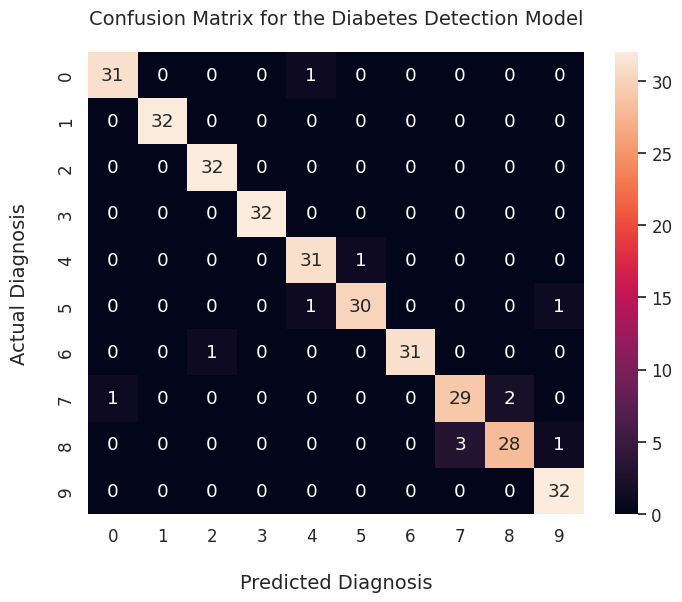

In [18]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [19]:
preds_val = model.model.predict(valid_generator)

10/10 [==============================] - 6s 574ms/step


In [20]:
evaluate_val = model.model.evaluate(valid_generator)

10/10 [==============================] - 6s 539ms/step - loss: 4.8846 - accuracy: 0.9605


In [21]:
evaluate_val

[4.884647846221924, 0.9605262875556946]

In [22]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 2, 7, 7, 7, 7, 8, 7,
       7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [23]:
y_real_val = valid_generator.classes
y_real_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [24]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9736842105263158

In [25]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 30,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 29,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 30,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 30,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 31,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0, 30,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0, 26,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 31,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1, 29]])

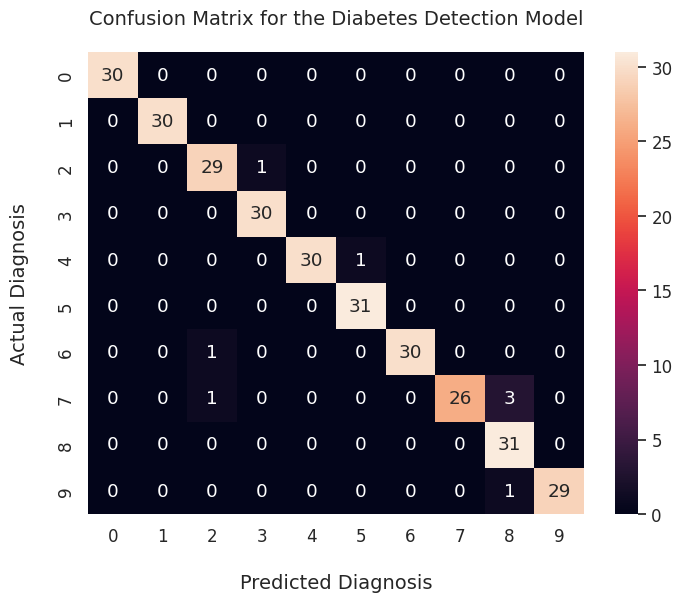

In [26]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()